In [1]:
import ROOT as r
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SC

Welcome to JupyROOT 6.22/02


In [2]:
background = r.TFile('D0_background.root')
signal = r.TFile('D0_Signal_MonteCarlo.root')

back_tree = background.Get('ntpD0BackgroundSameSignPt12')
sig_tree = signal.Get('ntpD0')

r.ROOT.EnableImplicitMT()

array, labels = sig_tree.AsMatrix(return_labels=True)
b_array, b_labels = back_tree.AsMatrix(return_labels=True)

b_array = b_array[:592372,:] #ograniczenie danych tła
array = array[(array[:, labels.index('pt')] >= 1) & (array[:, labels.index('pt')] <= 2)]

In [3]:
# skrocenie przedzialu 
array = array[array[:, 4] < 0.1]
b_array = b_array[b_array[:, 2] < 0.1]

In [4]:
sig_idxs = [labels.index(i) for i in b_labels]

In [5]:
weights = array[:,labels.index('matchHftWeight')] * [array[:,labels.index('w')]]

In [6]:
weights = np.transpose(weights)

In [7]:
# stala przez ktore mnozy sie wagi
const = 1/np.min(weights)

In [8]:
weights_list = weights[:,0]

In [9]:
#mnozenie wag w celu otrzymania intow
weights_int=[int(i*const*10) for i in weights_list]

In [10]:
weights_int = np.array(weights_int)

In [11]:
weights_int = np.expand_dims(weights_int, axis=1)

In [12]:
# dodanie do sygnalu kolumny z wagami
new_array = np.hstack((array,weights_int))

In [13]:
all_array = []
for i in range(14):
    all_array.append(0)

In [14]:
#stworzenie tablicy z duplikowanymi sygnalami na podstaiwe wag
for i in new_array[:10000,:]:
    for j in range(int(i[-1])):
        all_array = np.vstack((all_array, i))
all_array = all_array[~np.all(all_array == 0, axis=1)] #usuwam wiersze z zerami

In [16]:
a = all_array[:, sig_idxs]
zero = np.zeros((len(b_array), 1))
one = np.ones((len(a),1))

In [17]:
sig1 = np.hstack((a[:1000,:],one[:1000]))
back1 = np.hstack((b_array[:1000,:],zero[:1000]))
data1 = np.vstack((sig1,back1))

In [18]:
back10 = np.hstack((b_array[:10000,:],zero[:10000]))
data10 = np.vstack((sig1,back10))

In [19]:
back100 = np.hstack((b_array[:100000,:],zero[:100000]))
data100 = np.vstack((sig1,back100))

In [20]:
data1_wth_mass = data1[:,1:]
data10_wth_mass = data10[:,1:]
data100_wth_mass = data100[:,1:]

In [21]:
np.random.shuffle(data1_wth_mass)
np.random.shuffle(data10_wth_mass)
np.random.shuffle(data10_wth_mass)

In [22]:
np.save('data1', data1_wth_mass)
np.save('data10', data10_wth_mass)
np.save('data100', data100_wth_mass)

[5.09365274e-01 3.27013398e-01 1.41623570e-01 2.13612740e-02
 5.78264438e-04 3.55210497e-05 1.17879580e-05 6.61247744e-06
 4.29815431e-06]
[23.60399764 18.91270591 12.44625413  4.83375319  0.79530578  0.19711233
  0.1135508   0.08504582  0.06856649]
[2.78713709e-01 1.78934690e-01 7.74933676e-02 1.16884291e-02
 3.16413848e-04 1.94363535e-05 6.45011678e-06 3.61820526e-06
 2.35185748e-06]


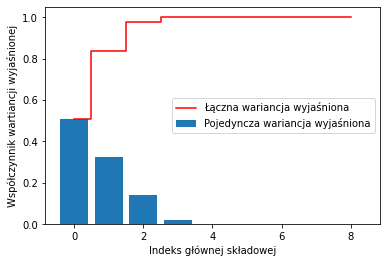

In [23]:
pca = PCA(n_components=data1_wth_mass.shape[1])
std_array=pca.fit_transform(data1_wth_mass)
pca.fit(std_array)
print(pca.explained_variance_ratio_)   #sumuje sie do 1
print(pca.singular_values_)
print(pca.explained_variance_)
plt.bar(range(0,data1_wth_mass.shape[1]),pca.explained_variance_ratio_,label ="Pojedyncza wariancja wyjaśniona")
plt.step(range(0,data1_wth_mass.shape[1]),np.cumsum(pca.explained_variance_ratio_),where='mid',color='red', label = "Łączna wariancja wyjaśniona")
plt.xlabel('Indeks głównej składowej')
plt.ylabel('Współczynnik wartiancji wyjaśnionej')
plt.legend(loc=7)
plt.savefig("pca",bbox_inches='tight')

plt.show()

# HISTOGRAMY

In [25]:
def histo(parametr, title,units):
    fig, ax1 = plt.subplots()
    ax1.hist(array[:, labels.index(parametr)],bins=100, color='g', label='signal',weights=weights, histtype='step')
    ax1.set_ylabel("signal",color='g')
    ax2 = ax1.twinx()
    ax2.set_ylabel('background',color='r')
    ax2.hist(b_array[:, b_labels.index(parametr)],bins=100, color='r',label='background',histtype='step')
    fig.tight_layout()
    plt.title(title+units)
    plt.savefig(title,bbox_inches='tight')
    plt.show()

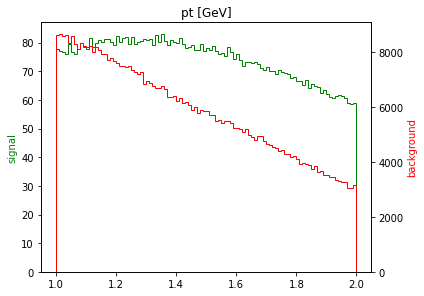

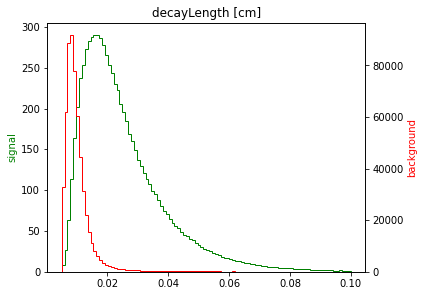

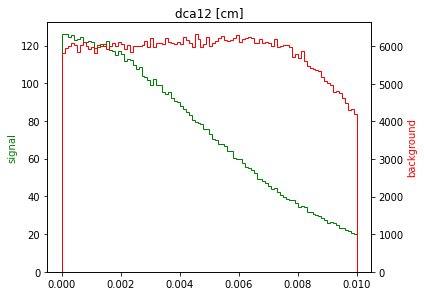

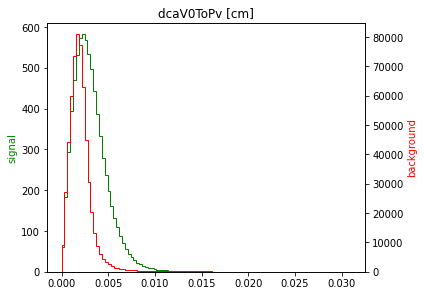

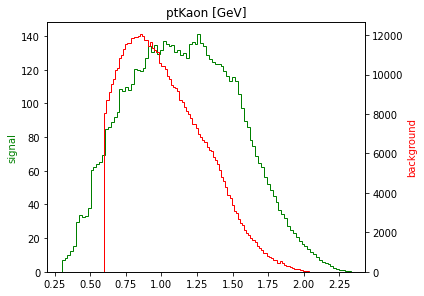

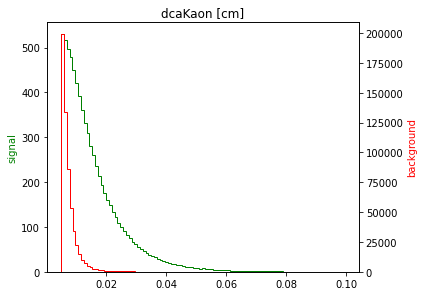

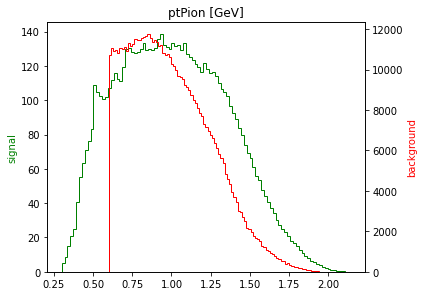

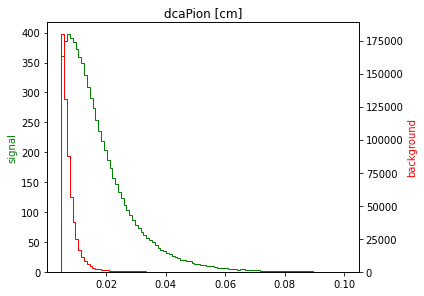

In [27]:
histo("pt","pt"," [GeV]")
histo("decayLength","decayLength", " [cm]")
histo("dca12","dca12", " [cm]")
histo("dcaV0ToPv","dcaV0ToPv", " [cm]")
histo("ptKaon","ptKaon" ," [GeV]")
histo("dcaKaon","dcaKaon", " [cm]")
histo("ptPion","ptPion"," [GeV]")
histo("dcaPion","dcaPion", " [cm]")


# HISTOGRAMY 2D

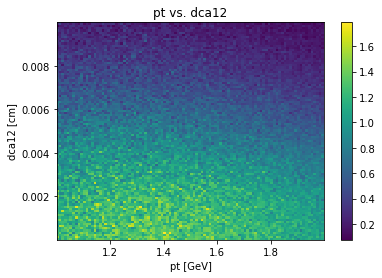

In [28]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("dca12")],bins=100,weights=weights[:,0])
plt.xlabel('pt [GeV]')
plt.ylabel('dca12 [cm]')
plt.title("pt vs. dca12")
plt.colorbar()
plt.savefig("pt_dca12",bbox_inches='tight')
plt.show()

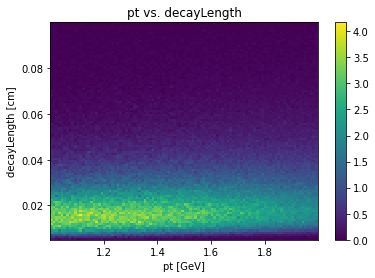

In [29]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("decayLength")],bins=100,weights=weights[:,0])
plt.xlabel('pt [GeV]')
plt.ylabel('decayLength [cm]')
plt.title("pt vs. decayLength")
plt.colorbar()
plt.savefig("pt_decayLength",bbox_inches='tight')
plt.show()

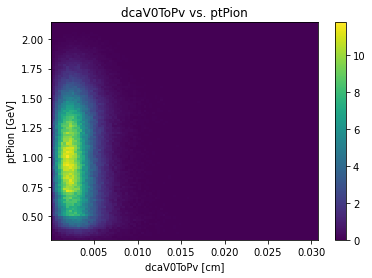

In [30]:
plt.hist2d(array[:, labels.index("dcaV0ToPv")],array[:, labels.index("ptPion")],bins=100,weights=weights[:,0])
plt.title("dcaV0ToPv vs. ptPion")
plt.colorbar()
plt.xlabel('dcaV0ToPv [cm]')
plt.ylabel('ptPion [GeV]')
plt.savefig("dcaV0ToPv_ptPion",bbox_inches='tight')
plt.show()

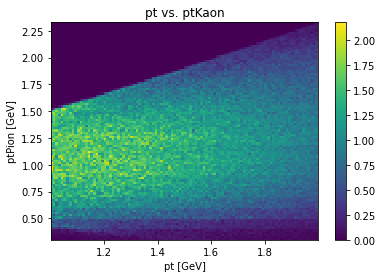

In [31]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("ptKaon")],bins=100,weights=weights[:,0])
plt.title("pt vs. ptKaon")
plt.xlabel('pt [GeV]')
plt.ylabel('ptPion [GeV]')
plt.colorbar()
plt.savefig("pt_ptKaon",bbox_inches='tight')
plt.show()

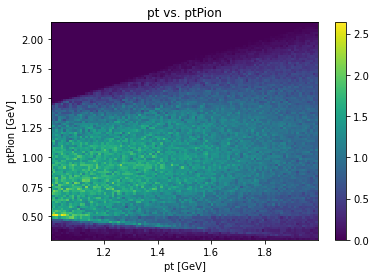

In [32]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("ptPion")],bins=100,weights=weights[:,0])
plt.title("pt vs. ptPion")
plt.colorbar()
plt.xlabel('pt [GeV]')
plt.ylabel('ptPion [GeV]')
plt.savefig("pt_ptPion",bbox_inches='tight')
plt.show()

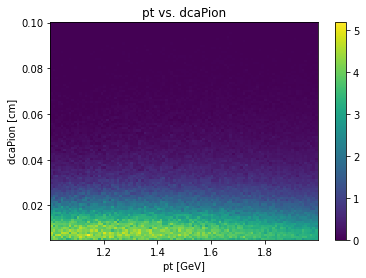

In [33]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("dcaPion")],bins=100,weights=weights[:,0])
plt.title("pt vs. dcaPion")
plt.xlabel('pt [GeV]')
plt.ylabel('dcaPion [cm]')
plt.colorbar()
plt.savefig("pt_dcaPion",bbox_inches='tight')
plt.show()

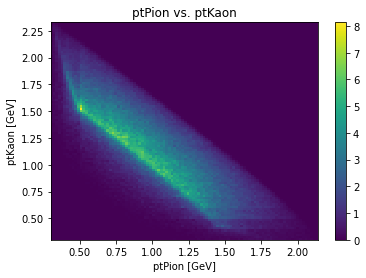

In [34]:
plt.hist2d(array[:, labels.index("ptPion")],array[:, labels.index("ptKaon")],bins=100,weights=weights[:,0])
plt.title("ptPion vs. ptKaon")
plt.xlabel('ptPion [GeV]')
plt.ylabel('ptKaon [GeV]')
plt.colorbar()
plt.savefig("ptPion_ptKaon",bbox_inches='tight')
plt.show()

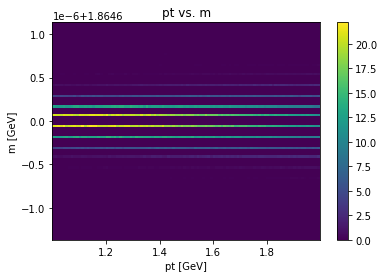

In [35]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("m")],bins=100,weights=weights[:,0])
plt.title("pt vs. m")
plt.xlabel('pt [GeV]')
plt.ylabel('m [GeV]')
plt.colorbar()
plt.savefig("pt_m",bbox_inches='tight')
plt.show()

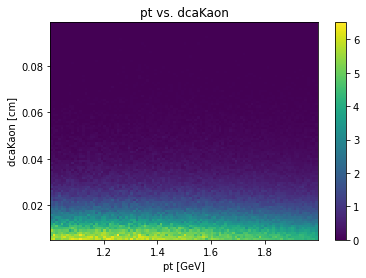

In [36]:
plt.hist2d(array[:, labels.index("pt")],array[:, labels.index("dcaKaon")],bins=100,weights=weights[:,0])
plt.title("pt vs. dcaKaon")
plt.xlabel('pt [GeV]')
plt.ylabel('dcaKaon [cm]')
plt.colorbar()
plt.savefig("pt_dcaKaon",bbox_inches='tight')
plt.show()

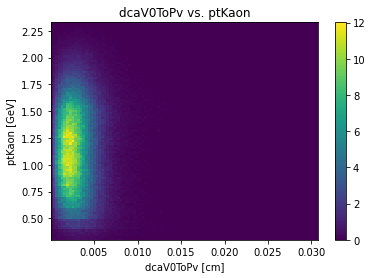

In [37]:
plt.hist2d(array[:, labels.index("dcaV0ToPv")],array[:, labels.index("ptKaon")],bins=100,weights=weights[:,0])
plt.title("dcaV0ToPv vs. ptKaon")
plt.xlabel('dcaV0ToPv [cm]')
plt.ylabel('ptKaon [GeV]')
plt.colorbar()
plt.savefig("dcaV0ToPv_ptKaon",bbox_inches='tight')
plt.show()